In [6]:
from matplotlib import pyplot as plt
import matplotlib as mpl
import numpy as np
import torch
import math
import pickle
from tqdm import tqdm
from PIL import Image
from crp.image import imgify, vis_opaque_img, plot_grid
import json
from sklearn.manifold import TSNE, Isomap
from sklearn.decomposition import PCA
from sklearn.cluster import SpectralClustering, KMeans, SpectralClustering

In [119]:

with open("metadata.pickle", "rb") as mf:
    metadata = pickle.load(mf)
    latents_sizes = np.array(metadata["latents_sizes"])
    latents_bases = np.concatenate(
        (
            latents_sizes[::-1].cumprod()[::-1][1:],
            np.array(
                [
                    1,
                ]
            ),
        )
    )
    latents_names = [i.decode("ascii") for i in metadata["latents_names"]]
    latents_names[0] = "watermark"

In [39]:
with open("outputs/measures.json", "r") as f:
    analysis_data = json.load(f)
    alldata = sorted(analysis_data.values(), key=lambda x: x["bias"])
    biases = [a["bias"] for a in alldata]
styles = ["solid", "dotted", "dashed", "dashdot"]

In [170]:
colors = mpl.cm.gist_rainbow(np.linspace(0, 1, 10))  # gist_ncar

In [135]:
# REDUCE BIAS INTERVAL
b = 0.5
filtbiases = [
    a["bias"] for a in list(filter(lambda x: x["learning_rate"] == 0.001 and x["bias"] > b, alldata))
]
datas =[[],[],[],[]]
datas[0] = list(filter(lambda x: x["learning_rate"] == 0.001 and x["bias"] > b, alldata))

datas[1] = list(filter(lambda x: x["learning_rate"] == 0.0015 and x["bias"] > b, alldata))

datas[2] = list(filter(lambda x: x["learning_rate"] == 0.002 and x["bias"] > b, alldata))

datas[3] = list(filter(lambda x: x["learning_rate"] == 0.0005 and x["bias"] > b, alldata))

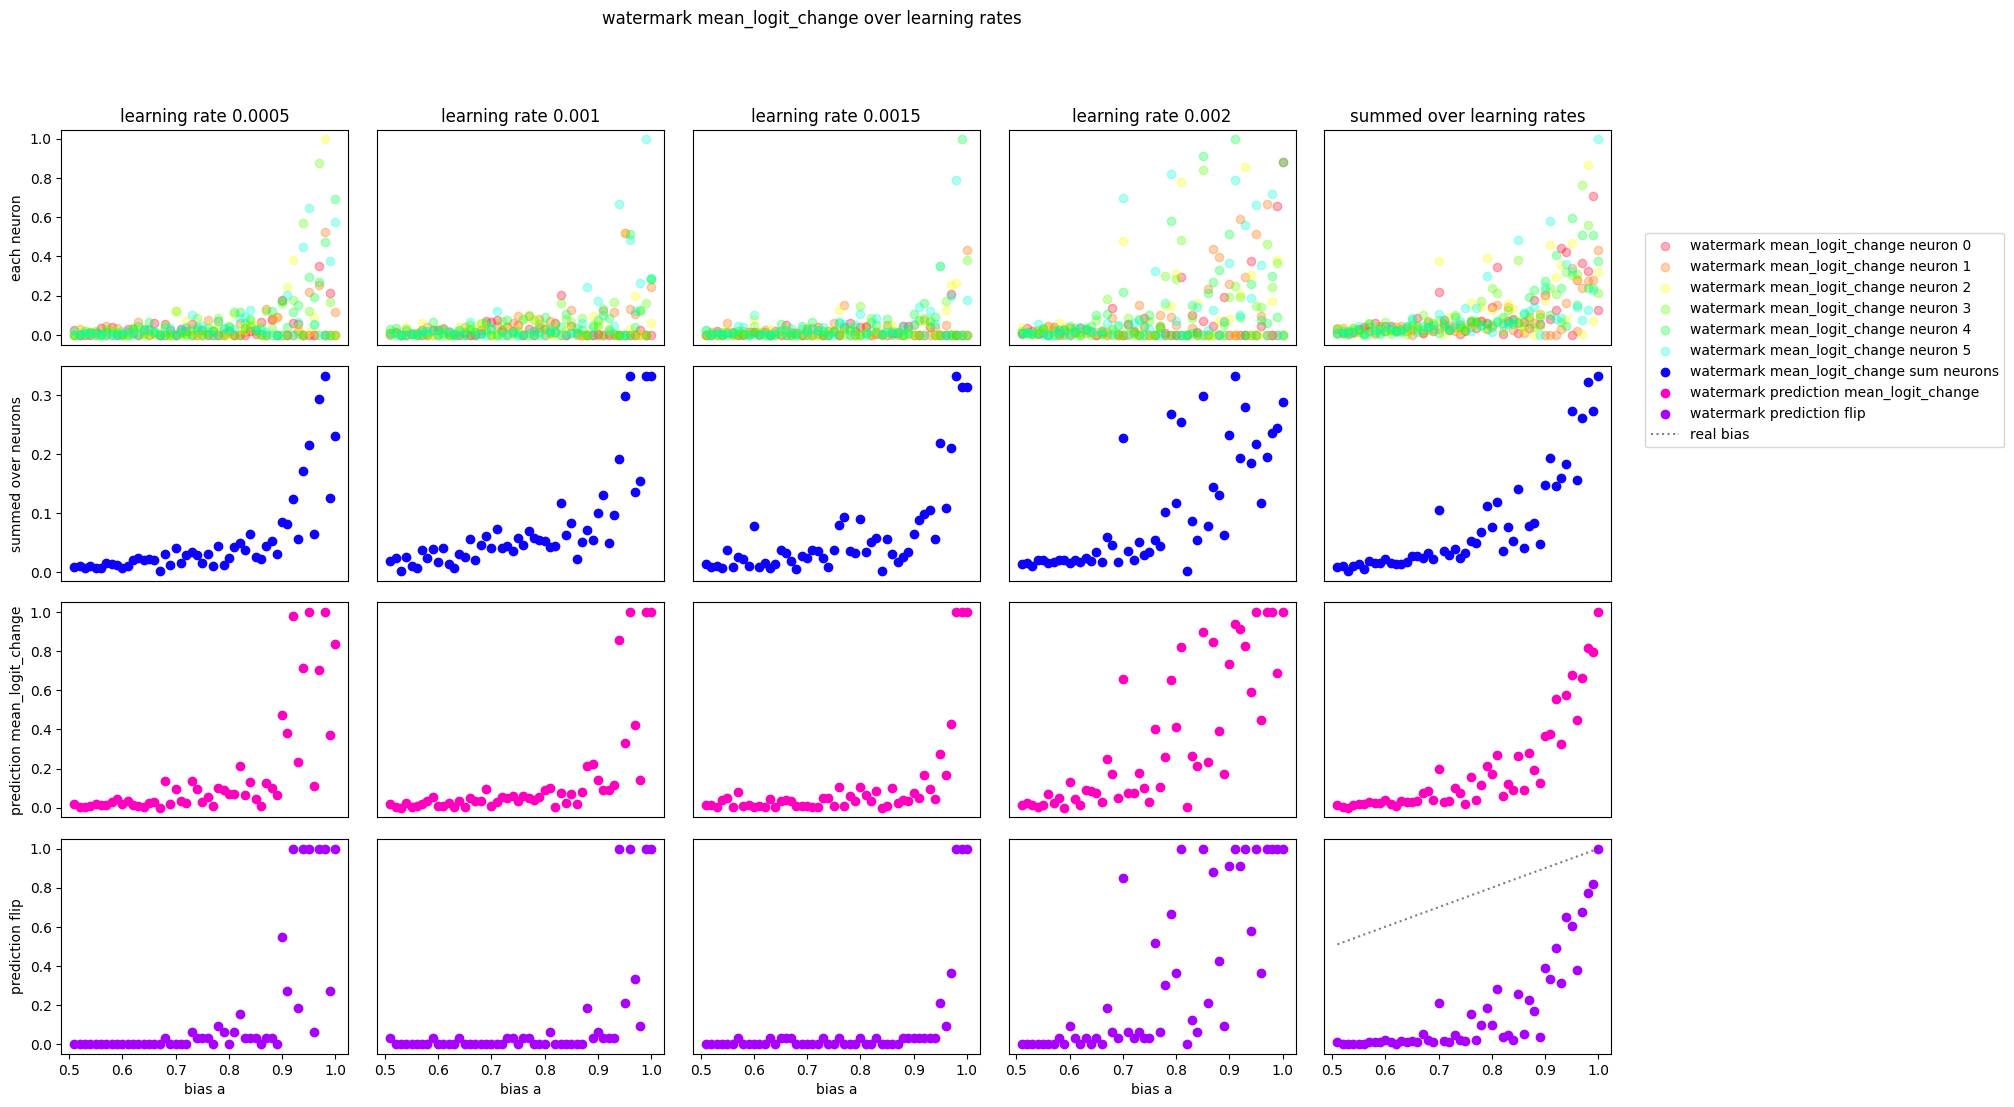

In [171]:
m_type =  "mean_logit_change"#"ols"  #

factor = 0

lrindex = 0
lrs = [0.0005, 0.001, 0.0015, 0.002]
lr = lrs[lrindex]

def plot_linear_layer(items, biasitems, factor=0):
    fig, axs = plt.subplots(
        4, 5, figsize=(20, 12), gridspec_kw={"wspace": 0.1, "hspace": 0.1}
    )
    for l in range(4):
        allneurons = np.array([a[f"crp_{m_type}"][factor] for a in items[l]])
        sums = np.sum(allneurons, 0)
        summed_neurons = np.sum(allneurons, 1) / 6
        summed_prediction = [
            np.sum(items[l][i][f"pred_{m_type}"][factor]) for i in range(len(items[0]))
        ]
        prediction_flips = [
            items[l][i]["pred_flip"][factor] for i in range(len(items[0]))
        ]
        orders = np.argsort(sums)
        for i in range(6):
            n = orders[i]
            label = f"{latents_names[factor]} {m_type} neuron {i}" if l == 0 else ""
            axs[0, l].set_title(f"learning rate {lrs[l]}")
            axs[3, l].set_xlabel("bias a")
            axs[0, l].scatter(
                filtbiases,
                allneurons[:, n],
                color=colors[i],
                label=label,
                alpha=0.3,
            )
            axs[0, l].xaxis.set_visible(False)
            axs[1, l].xaxis.set_visible(False)
            axs[2, l].xaxis.set_visible(False)
            if l == 0:
                sum_per_neuron = np.array(
                    [
                        np.sum(
                            [items[a][x][f"crp_{m_type}"][factor][n] for a in range(4)]
                        )
                        / 4
                        for x in range(len(items[0]))
                    ]
                )
                axs[0, 4].scatter(
                    filtbiases,
                    sum_per_neuron,
                    color=colors[i],
                    alpha=0.3,
                )
            else:
                axs[0, l].yaxis.set_visible(False)
                axs[1, l].yaxis.set_visible(False)
                axs[2, l].yaxis.set_visible(False)
                axs[3, l].yaxis.set_visible(False)
        axs[1, l].scatter(
            filtbiases,
            summed_neurons,
            color=colors[7],
            label=f"{latents_names[factor]} {m_type} sum neurons" if l == 0 else "",
        )
        axs[2, l].scatter(
            biasitems,
            summed_prediction,
            color=colors[9],
            label=f"{latents_names[factor]} prediction {m_type}" if l == 0 else "",
        )
        axs[3, l].scatter(
            biasitems,
            prediction_flips,
            color=colors[8],
            label=f"{latents_names[factor]} prediction flip" if l == 0 else "",
        )

    summed_neurons = [
        np.sum([datas[a][i][f"crp_{m_type}"][factor] for a in range(4)]) / 24
        for i in range(len(items[0]))
    ]
    summed_prediction = [
        np.sum([datas[a][i][f"pred_{m_type}"][factor] for a in range(4)]) / 4
        for i in range(len(items[0]))
    ]
    prediction_flips = [
        np.sum([datas[a][i]["pred_flip"][factor] for a in range(4)]) / 4
        for i in range(len(items[0]))
    ]
    axs[0, 4].set_title("summed over learning rates")
    axs[0, 0].set_ylabel("each neuron")
    axs[1, 0].set_ylabel("summed over neurons")
    axs[2, 0].set_ylabel(f"prediction {m_type}")
    axs[3, 0].set_ylabel("prediction flip")
    for o in range(3):
        axs[o, 4].xaxis.set_visible(False)
        axs[o, 4].yaxis.set_visible(False)
    axs[3, 4].yaxis.set_visible(False)
    axs[1, 4].scatter(
        biasitems,
        summed_neurons,
        color=colors[7],
    )
    axs[2, 4].scatter(
        biasitems,
        summed_prediction,
        color=colors[9],
    )
    axs[3, 4].scatter(
        biasitems,
        prediction_flips,
        color=colors[8],
    )
    axs[3, 4].plot(
        biasitems,
        [i for i in biasitems],
        color="#000",
        label="real bias",
        linestyle="dotted",
        alpha=0.5,
    )

    fig.legend(bbox_to_anchor=(1.1, 0.8))
    fig.suptitle(f"{latents_names[factor]} {m_type} over learning rates")



plot_linear_layer(datas, filtbiases, factor)

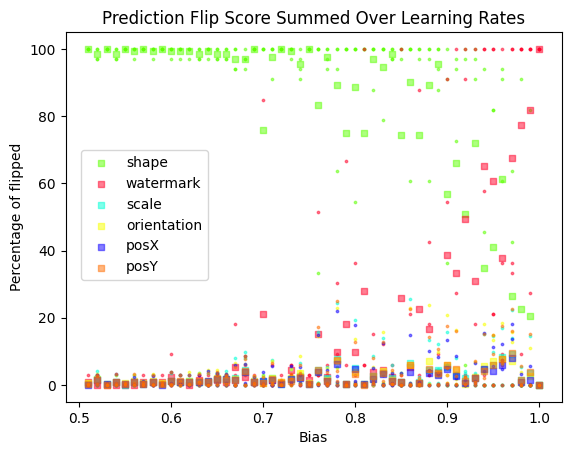

In [172]:
colind = [0,3,5,2,7,1]
def plot_pred_flip():
    for f in [1,0,2,3,4,5]:
        lat_data = [np.sum([datas[a][i][f"pred_flip"][f] for a in range(4)]) / 0.04 for i in range(len(datas[0]))]
        # on lr type: [a["pred_flip"][i] for a in datas[lrindex]]
        plt.scatter(filtbiases, lat_data, color=colors[colind[f]], label=latents_names[f], alpha=0.5, s=20, marker="s")
        for l in range(4):
            lat_data = [a[f"pred_flip"][f]*100 for a in datas[l]]
            plt.scatter(filtbiases, lat_data, color=colors[colind[f]], s=3, alpha=0.5)
    plt.legend(loc="upper left")
    plt.ylabel("Percentage of flipped")
    plt.xlabel("Bias")
    plt.title("Prediction Flip Score Summed Over Learning Rates")
    plt.legend(bbox_to_anchor=(0.3, 0.7))
plot_pred_flip()

50 50
50 50
50 50
50 50


Text(0.5, 1.0, 'watermark Mean Logit Change Summed over learning rates')

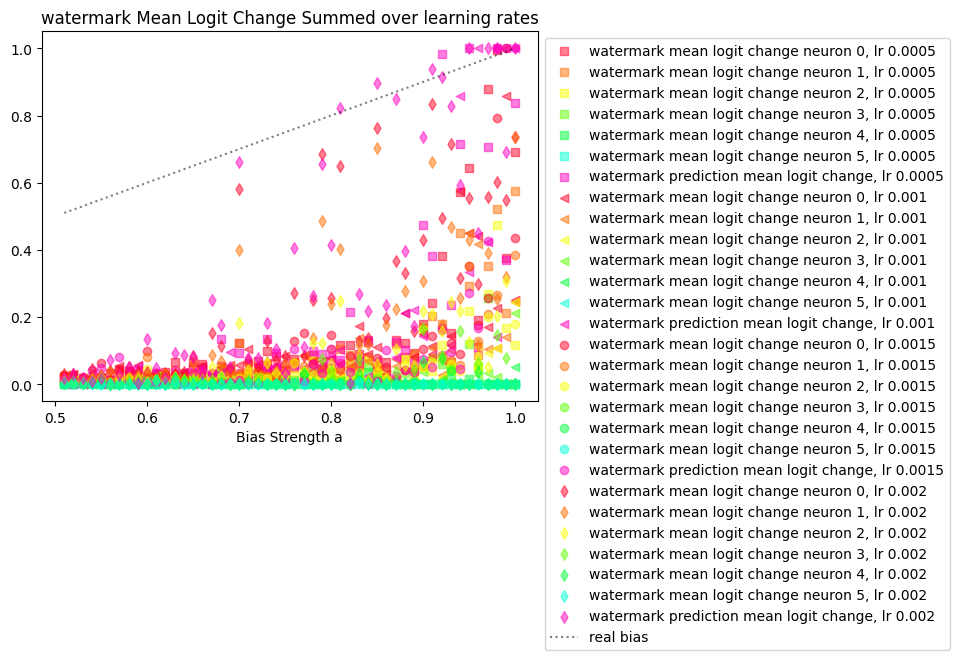

In [173]:
def plot_linear_layer(items, biasitems, factor=0):
    shapes = ["s", "<", "o", "d"]
    for i in range(4):
        print(len(items[i]), len(biasitems))
        sort_vals = [sorted([a["crp_mean_logit_change"][factor][n] for n in range(6)], reverse=True) for a in items[i]]
        for n in range(0,6):
            vals = [a[n] for a in sort_vals]
            #[a["crp_mean_logit_change"][factor][n] for a in items[i]]
            plt.scatter(
                biasitems,
                vals,
                color=colors[n],
                label=f"{latents_names[factor]} mean logit change neuron {n}, lr {lrs[i]}",
                marker=shapes[i],
                alpha=0.5,
            )
        plt.scatter(
            biasitems,
            [a["pred_mean_logit_change"][factor] for a in items[i]],
            color=colors[9],
            label=f"{latents_names[factor]} prediction mean logit change, lr {lrs[i]}",
            marker=shapes[i],
            alpha=0.5,
        )
    plt.plot(
        biasitems,
        biasitems,
        color="#000",
        label="real bias",
        linestyle="dotted",
        alpha=0.5,
    )


factor = 0
plot_linear_layer(datas, filtbiases,factor)
plt.legend(bbox_to_anchor=(1, 1))

plt.xlabel("Bias Strength a")
plt.title(f"{latents_names[factor]} Mean Logit Change Summed over learning rates")

Text(0.5, 1.0, 'Mean Logit Change Watermark vs Shape Summed over learning rates and neuron(s) 0')

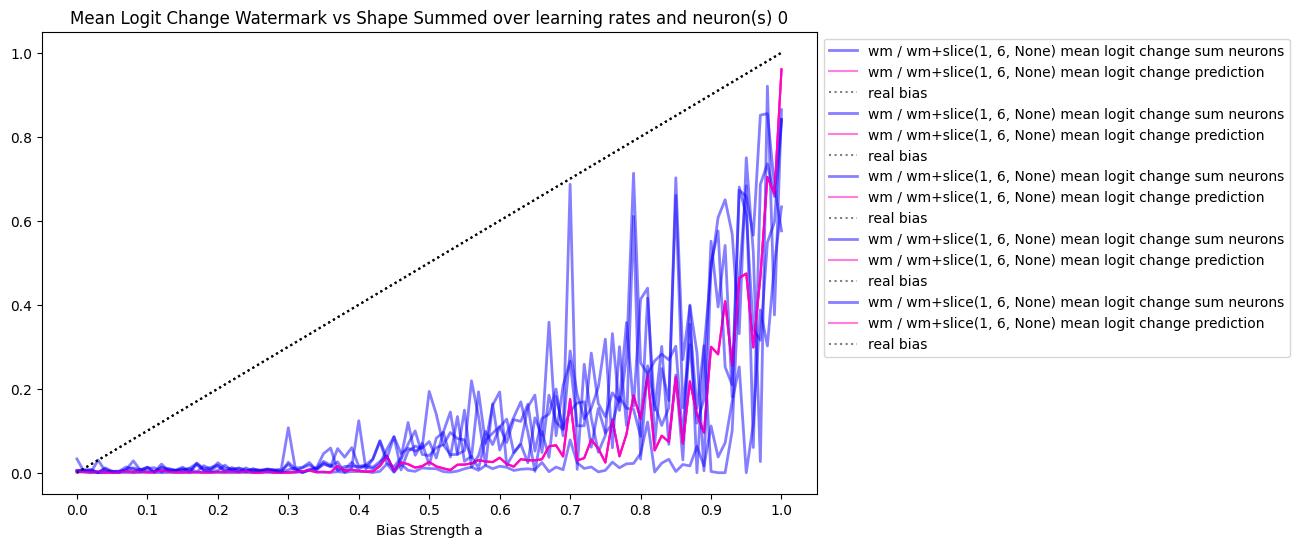

In [234]:
def plot_linear_layer(items, biasitems, neuron, f1, f2):
    summed_wm = [
        np.sum([datas[a][i]["crp_mean_logit_change"][f1][neuron] for a in range(4)]) / 4
        for i in range(len(items[0]))
    ]
    summed_sh = [
        np.sum([datas[a][i]["crp_mean_logit_change"][f2][neuron] for a in range(4)]) / 4
        for i in range(len(items[0]))
    ]
    summed_neurons = [
        summed_wm[i] / (summed_wm[i] + summed_sh[i]) for i in range(len(summed_wm))
    ]
    summed_p_wm = [
        np.sum([datas[a][i]["pred_mean_logit_change"][f1] for a in range(4)]) / 4
        for i in range(len(items[0]))
    ]
    summed_p_sh = [
        np.sum([datas[a][i]["pred_mean_logit_change"][f2] for a in range(4)]) / 4
        for i in range(len(items[0]))
    ]
    summed_prediction = [
        summed_p_wm[i] / (summed_p_wm[i] + summed_p_sh[i])
        for i in range(len(summed_wm))
    ]
    plt.plot(
        biasitems,
        summed_neurons,
        color=colors[7],
        label=f"wm / wm+{f2} mean logit change sum neurons",
        linewidth=2,
        alpha=0.5,
    )
    plt.plot(
        biasitems,
        summed_prediction,
        color=colors[9],
        label=f"wm / wm+{f2} mean logit change prediction",
        alpha=0.5,
    )
    plt.plot(
        biasitems,
        biasitems,
        color="#000",
        label="real bias",
        linestyle="dotted",
        alpha=0.5,
    )


neuron = 0#slice(0, 6)
f1 = 0
f2 = 1

plt.figure(figsize=(10,6))
plot_linear_layer(datas, filtbiases, neuron, f1, slice(1, 6))
plot_linear_layer(datas, filtbiases, 1, f1, slice(1, 6))
plot_linear_layer(datas, filtbiases, 2, f1, slice(1, 6))
plot_linear_layer(datas, filtbiases, 3, f1, slice(1, 6))
plot_linear_layer(datas, filtbiases, 4, f1, slice(1, 6))
#plot_linear_layer(datas, filtbiases, 5, f1, slice(1, 6))
# plot_linear_layer(datas, filtbiases, neuron, f2, f1)
plt.legend(bbox_to_anchor=(1, 1))
plt.xlabel("Bias Strength a")
plt.xticks(np.arange(0,1.1,0.1))
plt.title(
    f"Mean Logit Change Watermark vs Shape Summed over learning rates and neuron(s) {neuron}"
)

Text(0.5, 1.0, 'Mean Logit Change Watermark vs Shape Summed over learning rates and neuron(s) slice(0, 6, None)')

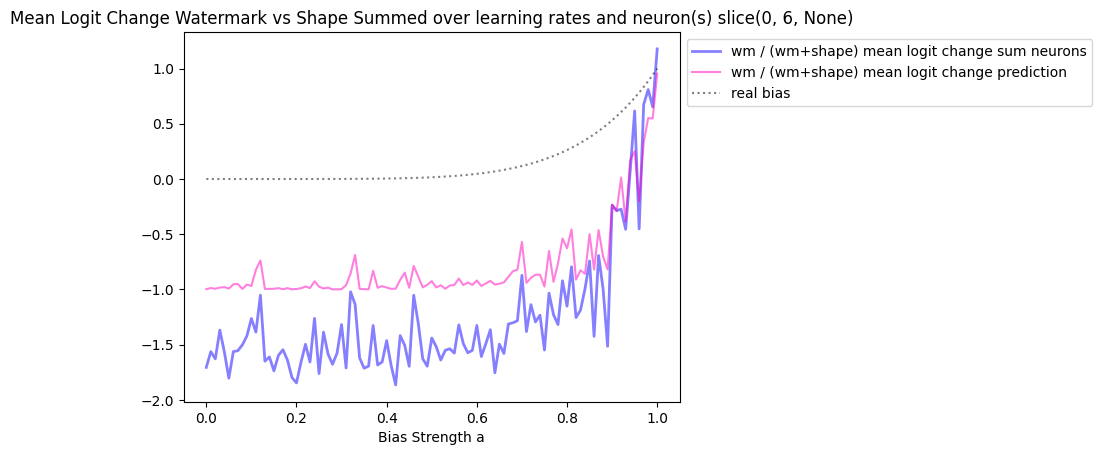

In [235]:
def plot_linear_layer(items, biasitems, neuron, f1, f2):
    summed_wm = [
        np.sum([datas[a][i]["crp_mean_logit_change"][f1][neuron] for a in range(4)]) / 4
        for i in range(len(items[0]))
    ]
    summed_sh = [
        np.sum([datas[a][i]["crp_mean_logit_change"][f2][neuron] for a in range(4)]) / 4
        for i in range(len(items[0]))
    ]
    summed_neurons = [(summed_wm[i] - summed_sh[i]) for i in range(len(summed_wm))]
    summed_p_wm = [
        np.sum([datas[a][i]["pred_mean_logit_change"][f1] for a in range(4)]) / 4
        for i in range(len(items[0]))
    ]
    summed_p_sh = [
        np.sum([datas[a][i]["pred_mean_logit_change"][f2] for a in range(4)]) / 4
        for i in range(len(items[0]))
    ]
    summed_prediction = [
        (summed_p_wm[i] - summed_p_sh[i]) for i in range(len(summed_wm))
    ]
    plt.plot(
        biasitems,
        summed_neurons,
        color=colors[7],
        label=f"wm / (wm+shape) mean logit change sum neurons",
        linewidth=2,
        alpha=0.5,
    )
    plt.plot(
        biasitems,
        summed_prediction,
        color=colors[9],
        label=f"wm / (wm+shape) mean logit change prediction",
        alpha=0.5,
    )
    plt.plot(
        biasitems,
        [i**6 for i in biasitems],
        color="#000",
        label="real bias",
        linestyle="dotted",
        alpha=0.5,
    )


neuron = slice(0, 6)
f1 = 0
f2 = 1
plot_linear_layer(datas, filtbiases, neuron, f1, f2)
plt.legend(bbox_to_anchor=(1, 1))

plt.xlabel("Bias Strength a")
plt.title(
    f"Mean Logit Change Watermark vs Shape Summed over learning rates and neuron(s) {neuron}"
)

Text(0.5, 1.0, 'Difference between summed neuron logit change and prediction logit change')

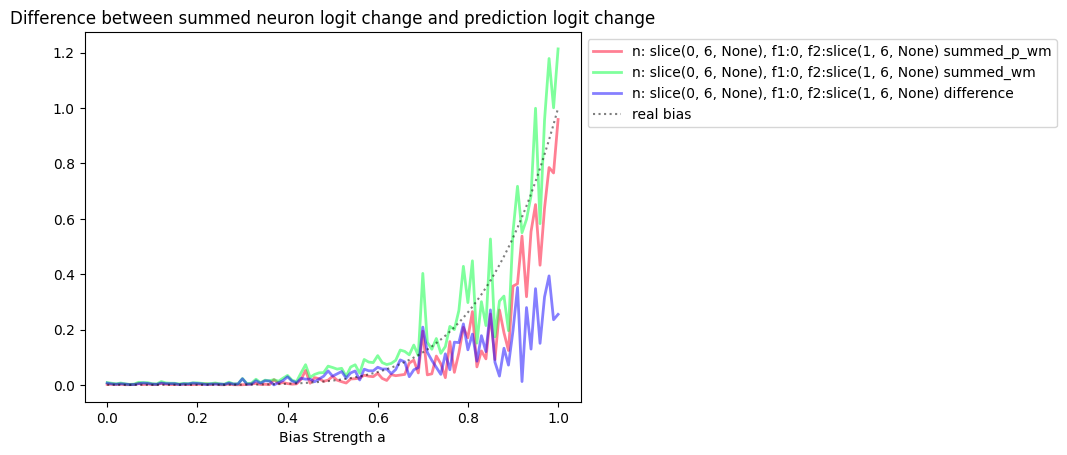

In [236]:
def plot_linear_layer(items, biasitems, neuron, f1, f2):
    summed_wm = [
        np.sum([datas[a][i]["crp_mean_logit_change"][f1][neuron] for a in range(4)]) / 4
        for i in range(len(items[0]))
    ]
    summed_sh = [
        np.sum([datas[a][i]["crp_mean_logit_change"][f2][neuron] for a in range(4)]) / 4
        for i in range(len(items[0]))
    ]
    summed_neurons = [(summed_wm[i] - summed_sh[i]) for i in range(len(summed_wm))]
    summed_p_wm = [
        np.sum([datas[a][i]["pred_mean_logit_change"][f1] for a in range(4)]) / 4
        for i in range(len(items[0]))
    ]
    summed_p_sh = [
        np.sum([datas[a][i]["pred_mean_logit_change"][f2] for a in range(4)]) / 4
        for i in range(len(items[0]))
    ]
    summed_prediction = [
        (summed_p_wm[i] - summed_p_sh[i]) for i in range(len(summed_wm))
    ]
    differences = [summed_wm[i] - summed_p_wm[i] for i in range(len(summed_neurons))]
    plt.plot(
        biasitems,
        summed_p_wm,
        color=colors[0],
        label=f"n: {neuron}, f1:{f1}, f2:{f2} summed_p_wm",
        linewidth=2,
        alpha=0.5,
    )
    plt.plot(
        biasitems,
        summed_wm,
        color=colors[4],
        label=f"n: {neuron}, f1:{f1}, f2:{f2} summed_wm",
        linewidth=2,
        alpha=0.5,
    )
    plt.plot(
        biasitems,
        differences,
        color=colors[7],
        label=f"n: {neuron}, f1:{f1}, f2:{f2} difference",
        linewidth=2,
        alpha=0.5,
    )
    plt.plot(
        biasitems,
        [i**6 for i in biasitems],
        color="#000",
        label="real bias",
        linestyle="dotted",
        alpha=0.5,
    )


neuron = slice(0, 6)
f1 = 0
f2 = slice(1, 6)  # 1
plot_linear_layer(datas, filtbiases, neuron, f1, f2)
plt.legend(bbox_to_anchor=(1, 1))

plt.xlabel("Bias Strength a")
plt.title("Difference between summed neuron logit change and prediction logit change")

Text(0.5, 1.0, 'Mean Logit Change Watermark vs Shape Summed over learning rates and neuron(s) slice(0, 6, None)')

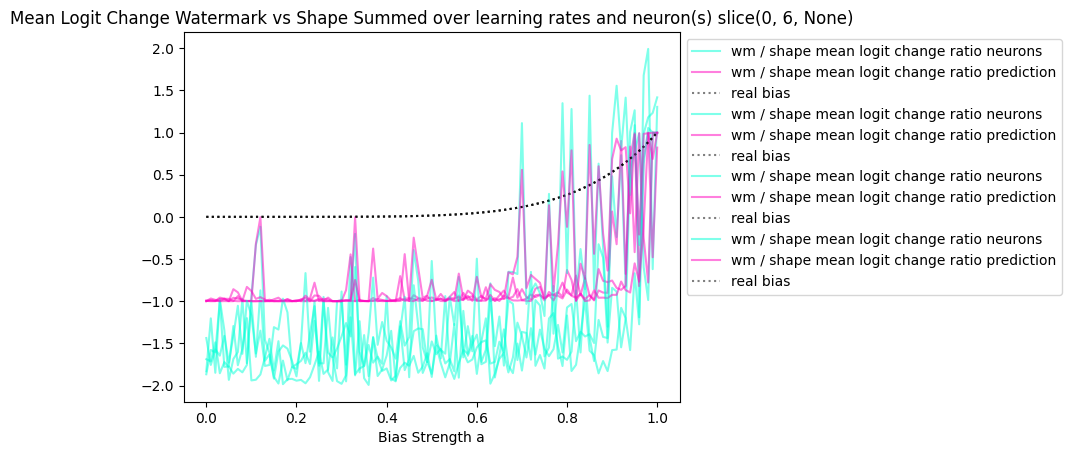

In [242]:
def plot_linear_layer(items, biasitems, neuron, f1, f2):
    summed_wm = [np.sum(a["crp_mean_logit_change"][f1]) for a in items]
    summed_sh = [np.sum(a["crp_mean_logit_change"][f2]) for a in items]
    summed_p_wm = [a["pred_mean_logit_change"][f1] for a in items]
    summed_p_sh = [a["pred_mean_logit_change"][f2] for a in items]
    summed_neurons = [
        (summed_wm[i] - (summed_sh[i] + 1e-10)) for i in range(len(summed_wm))
    ]
    summed_prediction = [
        (summed_p_wm[i] - (summed_p_sh[i] + 1e-10)) for i in range(len(summed_p_sh))
    ]
    plt.plot(
        biasitems,
        summed_neurons,
        color=colors[5],
        label=f"wm / shape mean logit change ratio neurons",
        alpha=0.5,
    )
    plt.plot(
        biasitems,
        summed_prediction,
        color=colors[9],
        label=f"wm / shape mean logit change ratio prediction",
        alpha=0.5,
    )
    plt.plot(
        biasitems,
        [i**6 for i in biasitems],
        color="#000",
        label="real bias",
        linestyle="dotted",
        alpha=0.5,
    )


neuron = slice(0, 6)
f1 = 0
f2 = 1
plot_linear_layer(datas[0], filtbiases, neuron, f1, f2)
plot_linear_layer(datas[1], filtbiases, neuron, f1, f2)
plot_linear_layer(datas[2], filtbiases, neuron, f1, f2)
plot_linear_layer(datas[3], filtbiases, neuron, f1, f2)
plt.legend(bbox_to_anchor=(1, 1))

plt.xlabel("Bias Strength a")
plt.title(
    f"Mean Logit Change Watermark vs Shape Summed over learning rates and neuron(s) {neuron}"
)